## Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

##### Likelihood in a Mixture Model:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves exploration

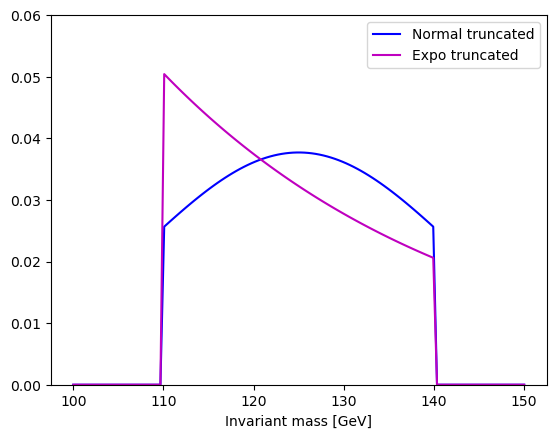

In [3]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [4]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [5]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

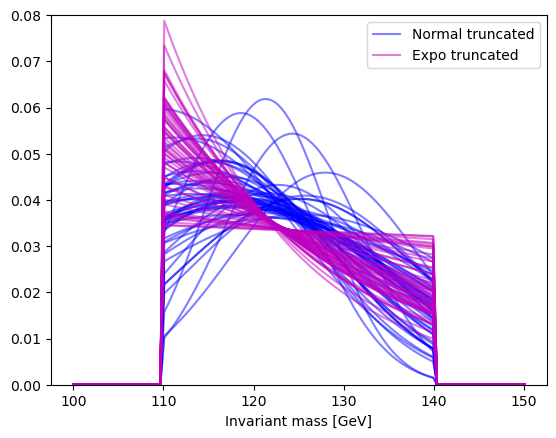

In [6]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

## Generate synthetic data

In [7]:
b=30
Lambda = 0.06
mu=120
sigma=7
###################
data = []
p = [0.7,0.3] # p[0] is background, p[1] is signal
np.random.seed(seed=0)
for i in range(5500):
    # Pay attention here: using binomial with p[1] means that if draws 1's then it is signal
    if np.random.binomial(1,p[1], size=1)[0] == 1: 
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])
    else:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
    
        

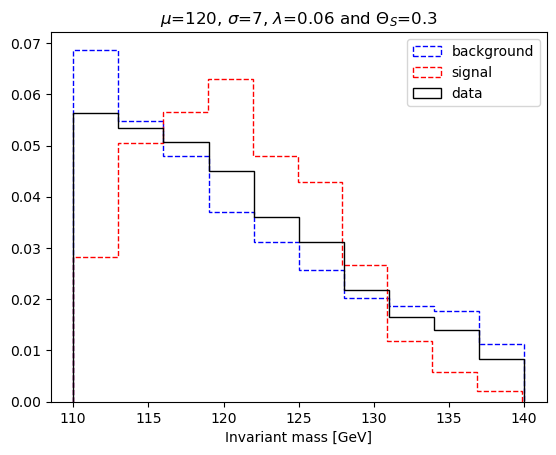

In [8]:
plt.hist([x[1] for x in data if x[2]==0], histtype='step', linestyle='dashed', color='blue', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', linestyle='dashed', color='red',  density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.xlabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

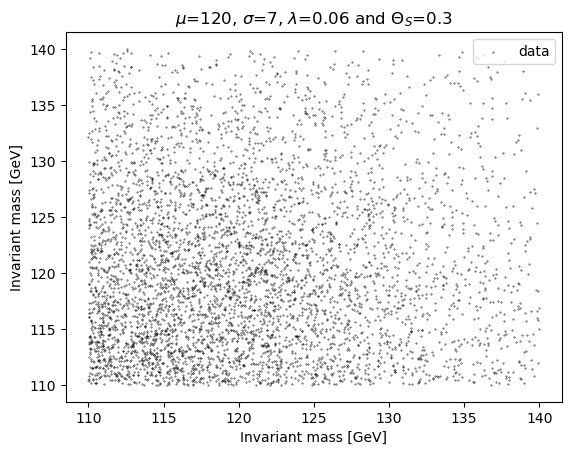

In [9]:
plt.scatter([x[0] for x in data[:5000]], [x[1] for x in data[:5000]], color='black', s=0.1, label='data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

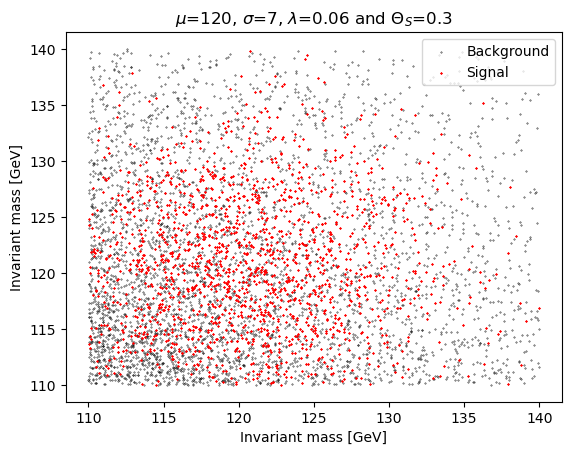

In [10]:
plt.scatter([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], color='black', s=0.1, label='Background')
plt.scatter([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], color='red', marker='x', s=0.5, label='Signal')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

## Stan inference

In [11]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 real L, U; // lower and upper limits of the observables (i.e. how to truncate the distributions)
 array[N,2] real<lower=L, upper=U> y;  // there are 2 observables per datapoint
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;  // hyperparameters for the parameters priors
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
    lp[1] =   exponential_lpdf( y[n,1] - L | lambda0)             
            - exponential_lcdf( U - L | lambda0) 
            + exponential_lpdf( y[n,2] - L| lambda0)
            - exponential_lcdf( U - L | lambda0);
     lp[2] =  normal_lpdf(y[n,1] | mu, sigma)
            - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) )             
            + normal_lpdf(y[n,2] | mu, sigma)
            - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) );

     // Pay attention here: theta[1] is associated to background, and theta[2] to signal, since we don't have theta[0]
     target += log_mix(theta, lp);                        
     };
}
"""

In [12]:
# Define hyperparameters that determine priors
mu0 = 120
sigma0 = 6
mu1 = 8
sigma1 =5
mu2 = Lambda*0.8
sigma2 = Lambda*0.2       
t1 = 1
t2 = 1

In [13]:
data_held = [[x[0], x[1]] for x in data[4500:5000]]
len(data_held)

500

In [14]:
# Observe that we only train with the first 5k datapoints!
passed_data = [[x[0], x[1]] for x in data[:5000]]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2,
           'L' : 110.0,
           'U' : 140.0
          }

In [15]:
model = stan.build(my_model, data=my_data, random_seed=0);

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s


In file included from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/concurrent_unordered_map.h:26,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/sequi/.cache/httpstan/4.13.0/models/5x5ykgah/model_5x5ykgah.cpp:2:
/home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/internal/_concurrent_unordered_impl.h: In instantiation of ‘void tbb::interface5::internal::concurrent_unordered_base<Traits>::internal_init() [

Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s


Building: 7.7s, done.
Messages from stanc:
Warning in '/tmp/httpstan_s99t6g23/model_5x5ykgah.stan', line 21, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [16]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.95)


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3301/8000)
Samplin

## Analyze results

In [17]:
df = fit.to_frame() 
df

parameters          lp__  accept_stat__  stepsize__  treedepth__  \
draws                                                              
0          -32601.416409       0.749906    0.122809          3.0   
1          -32597.370145       0.935079    0.144159          4.0   
2          -32598.389170       0.998341    0.139220          3.0   
3          -32598.278312       0.873708    0.124705          4.0   
4          -32599.001468       0.982245    0.122809          4.0   
...                  ...            ...         ...          ...   
3995       -32599.254611       0.960817    0.124705          3.0   
3996       -32598.069791       0.974096    0.122809          3.0   
3997       -32598.086948       0.991915    0.144159          4.0   
3998       -32598.335247       0.978390    0.139220          3.0   
3999       -32598.884448       0.960187    0.124705          2.0   

parameters  n_leapfrog__  divergent__      energy__          mu     sigma  \
draws                                                                       
0                   11.0          0.0  32603.626258  117.685657  8.271039   
1                   23.0          0.0  32602.439980  119.085285  7.933180   
2                   15.0          0.0  32599.491469  118.623467  8.119294   
3                   15.0          0.0  32601.313958  119.978440  6.928070   
4                   31.0          0.0  32603.532116  119.675021  8.016112   
...                  ...          ...           ...         ...       ...   
3995                15.0          0.0  32599.738460  118.719960  7.843039   
3996                15.0          0.0  32599.432548  119.579151  7.441541   
3997                15.0          0.0  32598.758082  120.395081  6.756016   
3998                13.0          0.0  32599.466025  119.367289  7.466608   
3999                 7.0          0.0  32600.628017  118.140709  7.730066   

parameters   lambda0   theta.1   theta.2  
draws                                     
0           0.061516  0.592950  0.407050  
1           0.062076  0.653311  0.346689  
2           0.063009  0.601147  0.398853  
3           0.064491  0.687509  0.312491  
4           0.064938  0.639632  0.360368  
...              ...       ...       ...  
3995        0.058718  0.606258  0.393742  
3996        0.061194  0.669455  0.330545  
3997        0.065734  0.741892  0.258108  
3998        0.061438  0.644409  0.355591  
3999        0.058298  0.624629  0.375371  

[4000 rows x 12 columns]

In [18]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda0     0.062  0.003    0.055    0.067      0.000    0.000    1514.0   
mu        119.003  1.128  116.988  120.862      0.040    0.028     842.0   
sigma       7.635  1.001    5.808    9.421      0.036    0.025     784.0   
theta[0]    0.663  0.077    0.519    0.793      0.003    0.002     785.0   
theta[1]    0.337  0.077    0.207    0.481      0.003    0.002     785.0   

          ess_tail  r_hat  
lambda0     1541.0    1.0  
mu          1165.0    1.0  
sigma       1066.0    1.0  
theta[0]    1186.0    1.0  
theta[1]    1186.0    1.0

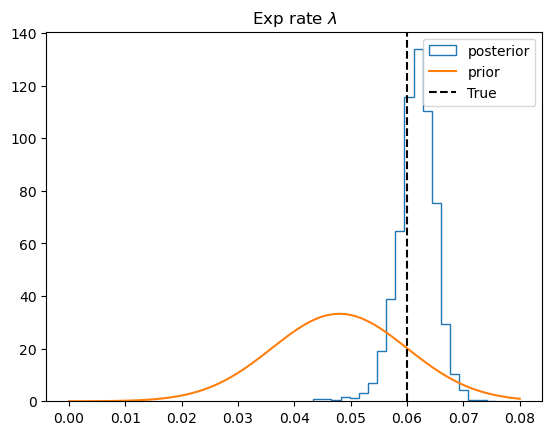

In [19]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.title('Exp rate $\lambda$')
plt.legend()
plt.show()

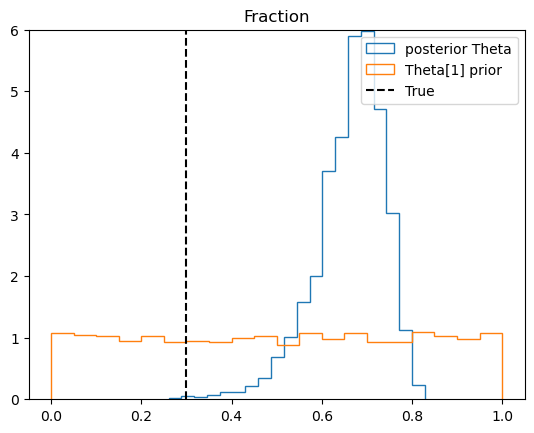

In [20]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.1'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
#plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=p[1], linestyle='dashed', color='black', label='True')
plt.ylim(0,6)
plt.title('Fraction')
plt.legend()
plt.show()

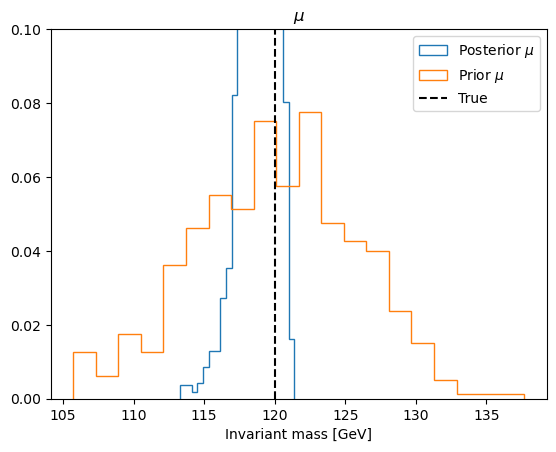

In [21]:
x=np.linspace(100,150,100)
plt.hist(df['mu'], histtype='step', density=1, bins=20, label='Posterior $\mu$')
plt.hist([x for x in np.random.normal(mu0,sigma0,size=500)], density=1, histtype='step', bins=20, label='Prior $\mu$')
plt.axvline(x=mu, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.1)
plt.title('$\mu$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

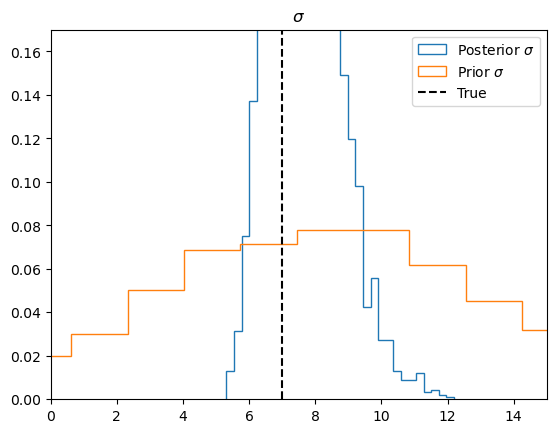

In [22]:
x=np.linspace(0,15,100)
plt.hist(df['sigma'], histtype='step', density=1, bins=30, label='Posterior $\sigma$')
plt.hist([x for x in np.random.normal(mu1,sigma1,size=1500)], density=1, histtype='step', bins=20, label='Prior $\sigma$')
plt.axvline(x=sigma, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.17)
plt.xlim(0,15)
plt.title('$\sigma$')
plt.legend()
plt.show()

## Posterior predictive check

#### Visualize the problem

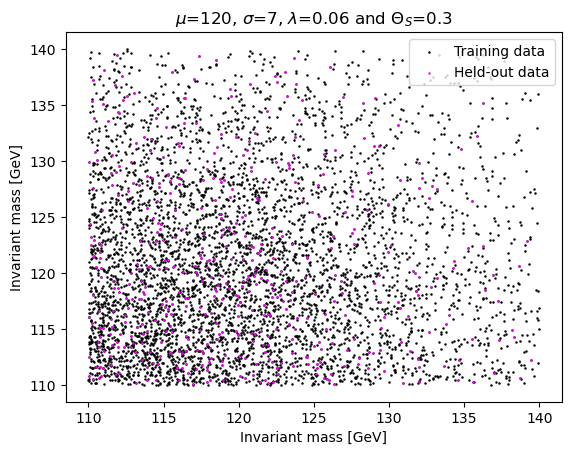

In [23]:
plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in data_held],[x[1] for x in data_held], color='magenta',  s=0.6, label='Held-out data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

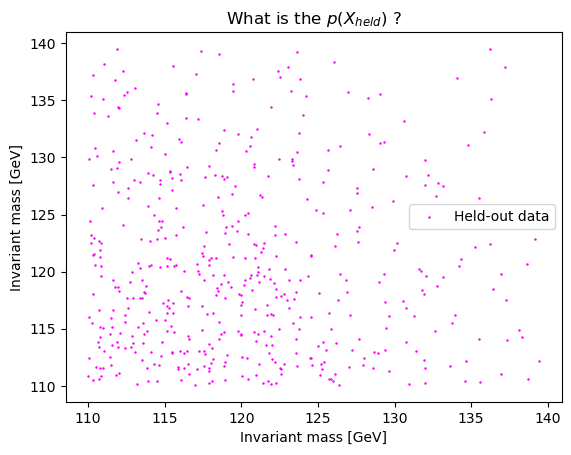

In [24]:
#plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in data_held],[x[1] for x in data_held], color='magenta',  s=0.6, label='Held-out data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('What is the $p(X_{held})$ ?')
plt.legend()
plt.show()

#### Generate tons of synthetic data to obtain the PDF of the inferred model

In [25]:
%%time
np.random.seed(0)
sinthetic = []
b = 30 # Truncated Exponential span
tons = 1000000
repeat = 10 # How many sinthetica data with the same sample of the 
samples = np.random.choice(range(len(df)), size=int(tons/repeat))
for i in range(len(samples)):
    if i%50000 == 0: print(i)
    # Pay attention here: the binomial argument should be the expected signal fraction, which is theta[2] (read in detail above and below how we use p)
    p = df.iloc[samples[i]]['theta.2'] 
    Lambda = df.iloc[samples[i]]['lambda0']
    mu = df.iloc[samples[i]]['mu']
    sigma = df.iloc[samples[i]]['sigma']
    # Here p is the probability of getting a 1, hence we should assign 1 to signal because p=theta.2
    classes = np.random.binomial(1,p,repeat) # Get repeated samples of a binomial with parameter of the signal fraction
    for j in range(repeat):
        if classes[j] == 0:
            sinthetic.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2)))
        else:
            sinthetic.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2)))                                

0
50000
CPU times: user 33.1 s, sys: 367 ms, total: 33.5 s
Wall time: 33.1 s


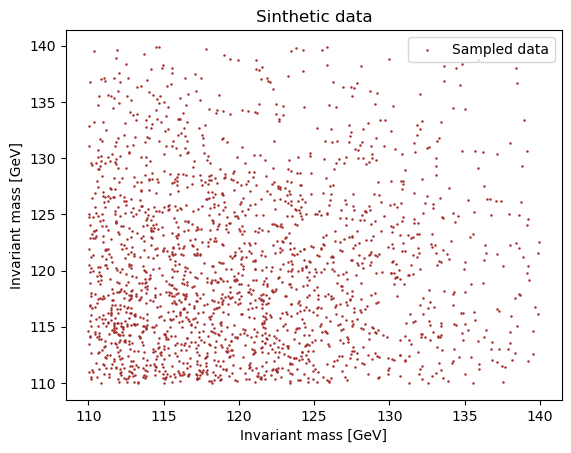

In [40]:
#plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in sinthetic[:2000]],[x[1] for x in sinthetic[:2000]], color='brown',  s=0.6, label='Sampled data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('Sinthetic data')
plt.legend()
plt.show()

In [26]:
# setup definitions
xmin, xmax, xbins = 110, 140, 15
ymin, ymax, ybins = 110, 140, 15
grid = np.zeros([ybins,xbins])

xstep = (xmax-xmin)/xbins
ystep = (ymax-ymin)/ybins
# fill the grid
for i in range(len(sinthetic)):
    if i%100000 == 0: print(i)
    xpos = int((sinthetic[i][0]-xmin)/xstep)
    ypos = ybins - 1 - int((sinthetic[i][1]-ymin)/ystep)
    grid[ypos][xpos] += 1

# Normalize
gridlog = np.zeros([ybins,xbins])
total = len(sinthetic)
for i in range(ybins):
    for j in range(xbins):
        grid[i][j] = grid[i][j]/total
        gridlog[i][j] = np.log(grid[i][j]/total)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


#### Heat-map as histogram for the PDF

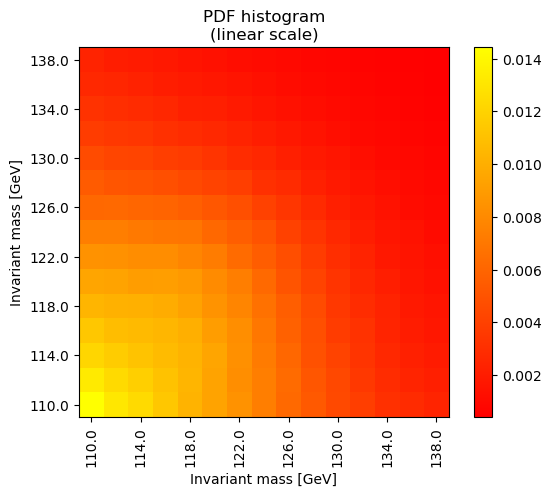

In [27]:
#tt = np.random.random((12, 12)) 
plt.imshow(grid, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.title("PDF histogram\n(linear scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.show() 

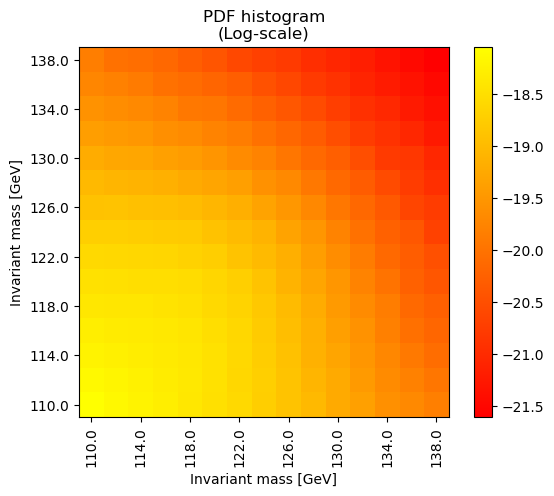

In [28]:
#tt = np.random.random((12, 12)) 
plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.title("PDF histogram\n(Log-scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.show() 

$$  p(x_n | X ) = \int p(x_n | z_i )\, p(z_i | X )\, dz_i $$

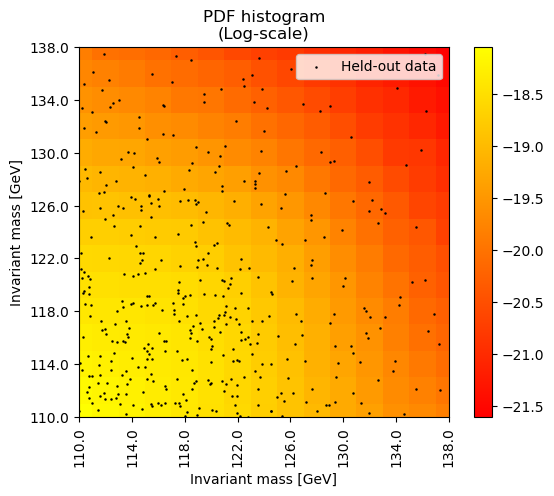

In [60]:
#tt = np.random.random((12, 12)) 
plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.scatter([(x[0]-110)/2 for x in data_held],[(140-x[1])/2 for x in data_held], color='black',  s=0.6, label='Held-out data')
plt.title("PDF histogram\n(Log-scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xlim(0,xbins-xstep/2)
plt.ylim(ybins-ystep/2, 0)
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.legend()
plt.show() 

#### Compute probability of $X_{held}$

In [29]:
def lp_data(l):
    lp = 0
    for i in range(len(l)):    
        xpos = int((l[i][0]-xmin)/xstep)
        ypos = ybins - 1 - int((l[i][1]-ymin)/ystep)
        lp += gridlog[ypos][xpos]
    return lp

In [74]:
lp_held = lp_data(data_held)
print('Probability of the data held-out Log(p(X_{held})) =',lp_held)

Probability of the data held-out Log(p(X_{held})) = -9459.424887553985


#### Generate replicas

In [31]:
%%time
np.random.seed(500)
replicas0 = []
b = 30 # Truncated Exponential span
tons = 300000
repeat = 10 # How many sinthetica data with the same sample of the 
samples = np.random.choice(range(len(df)), size=int(tons/repeat))
for i in range(len(samples)):
    p = df.iloc[samples[i]]['theta.2']
    Lambda = df.iloc[samples[i]]['lambda0']
    mu = df.iloc[samples[i]]['mu']
    sigma = df.iloc[samples[i]]['sigma']
    classes = np.random.binomial(1,p,repeat) # Get repeat sampels of a binomial with parameter of the sampled
    for j in range(repeat):
        if classes[j] == 0:
            replicas0.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2)))
        else:
            replicas0.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2)))                                

CPU times: user 10 s, sys: 143 ms, total: 10.2 s
Wall time: 9.98 s


In [32]:
replicas = []
for k in range(int(len(replicas0)/len(data_held) - 1)):
    replicas.append(replicas0[k*len(data_held):(k+1)*len(data_held)])

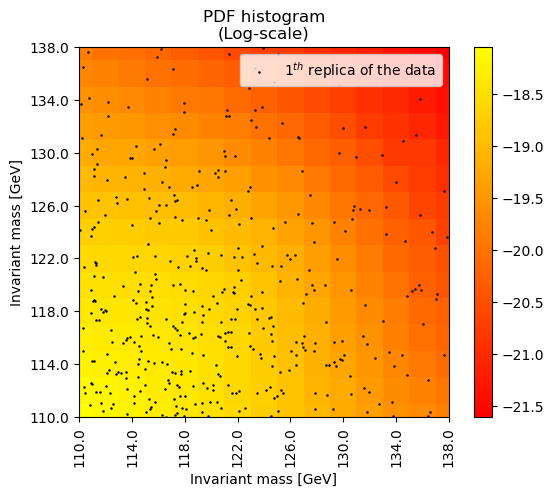

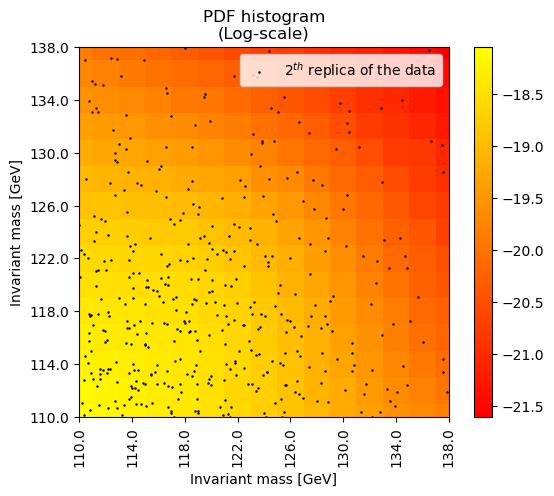

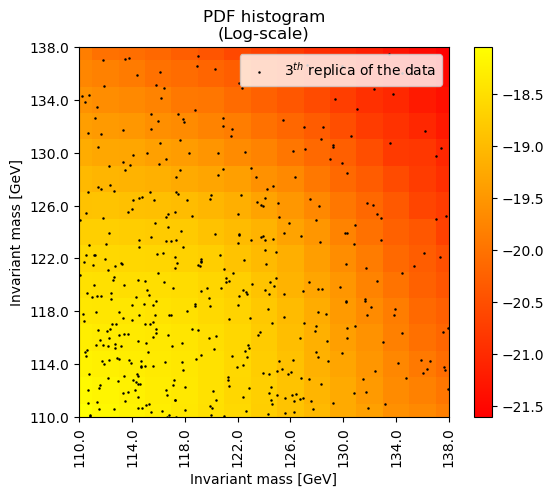

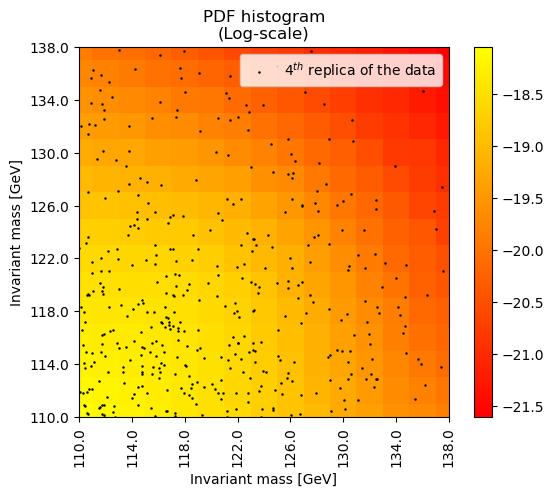

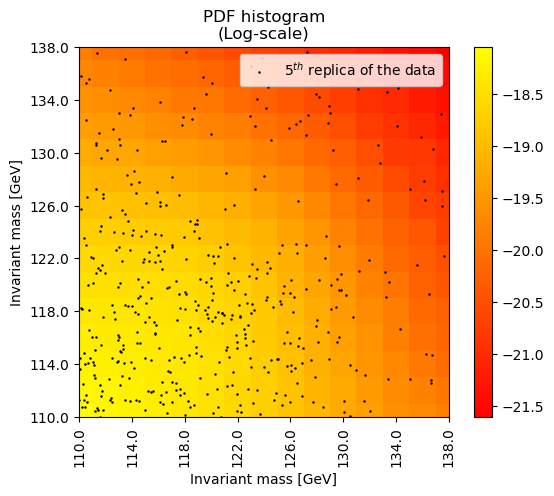

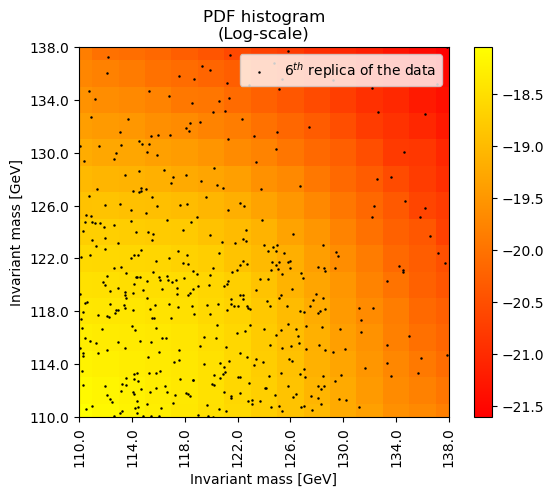

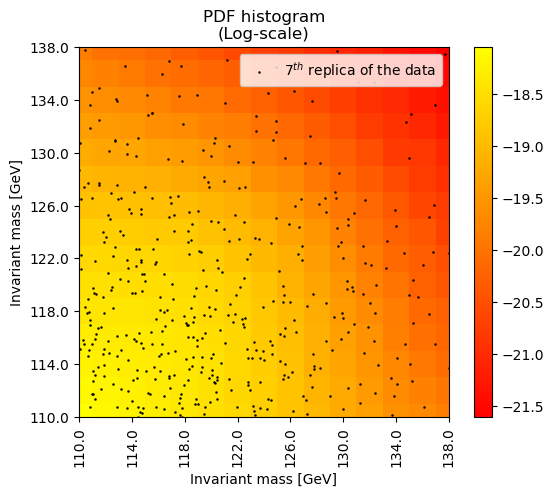

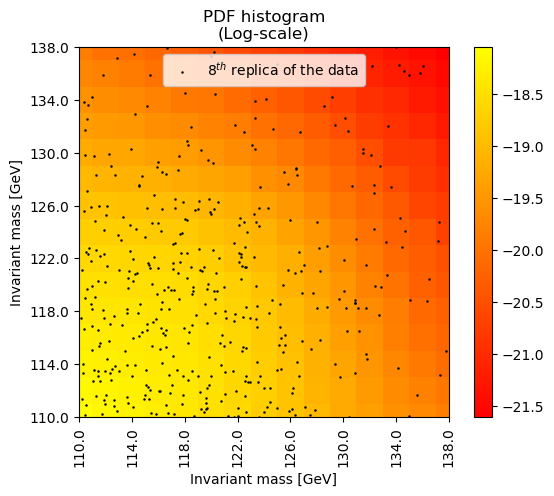

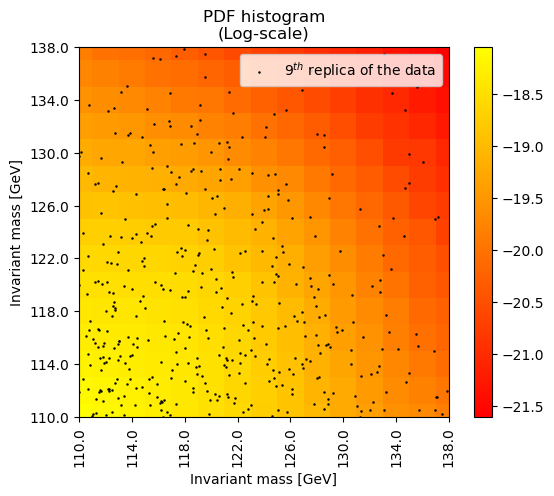

In [70]:
for i in range(1,10):
    plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
    plt.colorbar()   
    plt.scatter([(x[0]-110)/2 for x in replicas[i]],[(140-x[1])/2 for x in replicas[i]], color='black',  s=0.6, label=str(i)+'$^{th}$ replica of the data')
    plt.title("PDF histogram\n(Log-scale)")
    plt.xlabel('Invariant mass [GeV]')
    plt.ylabel('Invariant mass [GeV]')
    plt.xlim(0,xbins-xstep/2)
    plt.ylim(ybins-ystep/2, 0)
    plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
    plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
    plt.legend()
    plt.savefig('figs/replicas_'+str(i)+'.png')
    plt.show() 

In [129]:
# Count how many times the replicas prob is less than the held_out
count = 0
total = 0
lp_replicas = []
for i in range(len(replicas)):
    lp_replicas.append(lp_data(replicas[i]))
    if lp_replicas[-1] < lp_held:
        count += 1
    total += 1    

count/total

0.8664440734557596

In [128]:
# Extract the relevant info from the histogram plot for the next computations
a = plt.hist(lp_replicas, histtype='step', density=1, bins=15, label='Replicas of the data');
plt.close()

##### Compute the probability of having less probability than the held-out data

https://arxiv.org/pdf/1805.06826

In [120]:
x00 = [a[1][0]]
y00 = [a[0][0], a[0][0]]
for i in range(1,11):
    x00 = x00 + [ a[1][i], a[1][i]]
    y00 = y00 + [a[0][i], a[0][i]]
x00.append(a[1][11])

In [125]:
0.5*sum(y00)*(x00[1]-x00[0])

0.8664440734558028

$$ p \left( \, p(X^{rep}_{held}) < p(X_{held}) \right) = 0.86 $$

##### Compute the area of the histogram where the p is less than the p(data)

In [105]:
xslow = [a[1][0], a[1][1], a[1][1],a[1][2], a[1][2], a[1][3], a[1][3], a[1][4], a[1][4], a[1][5]]
yslow = [a[0][0], a[0][0], a[0][1], a[0][1],a[0][2], a[0][2], a[0][3], a[0][3], a[0][4], a[0][4]]

In [95]:
xsup = [a[1][11], a[1][11],a[1][12], a[1][12], a[1][13], a[1][13], a[1][14], a[1][14], a[1][15]]
ysup = [a[0][10], a[0][11], a[0][11],a[0][12], a[0][12], a[0][13], a[0][13], a[0][14], a[0][14]]

In [104]:
score = (sum(yslow[::2]) + sum(ysup[::2])) * (a[1][12]-a[1][11])
score

0.3722871452420701

$$ p \left( \, p^2(X^{rep}_{held}) < p^2(X_{held}) \right) = 0.37 $$

#### Plotting

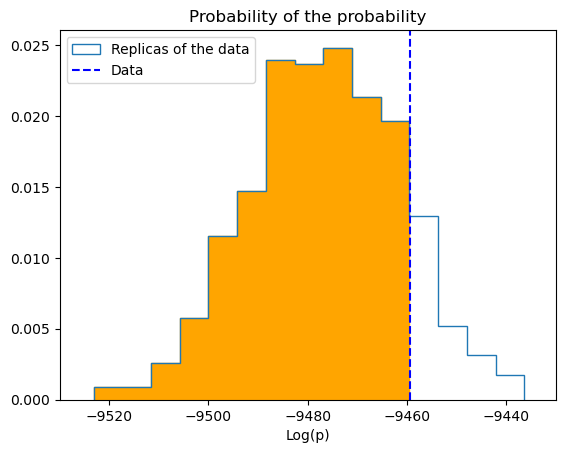

In [122]:
a = plt.hist(lp_replicas, histtype='step', density=1, bins=15, label='Replicas of the data')
plt.axvline(lp_held, linestyle='dashed', color='blue', label='Data')
#plt.fill_between(xslow, yslow, color='orange')
#plt.fill_between(xsup, ysup, color='orange')
plt.fill_between(x00, y00, color='orange')
plt.xlim(-9530,-9430)
plt.xlabel('Log(p)')
plt.title('Probability of the probability')
plt.legend()
plt.savefig('figs/posterior-predictive-check_03.png')
plt.show()